In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU


In [24]:
df = pd.read_csv("monthly_milk_production.csv")
df.head()


,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [25]:
df.columns = ['Month', 'Milk_Production']
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)


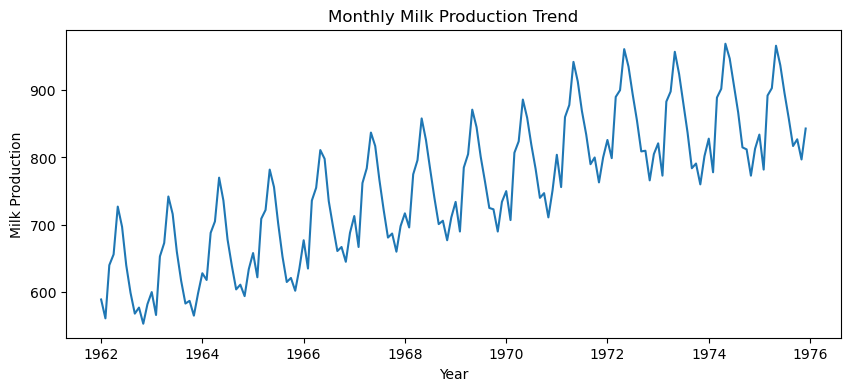

In [26]:
plt.figure(figsize=(10,4))
plt.plot(df['Milk_Production'])
plt.title("Monthly Milk Production Trend")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.show()


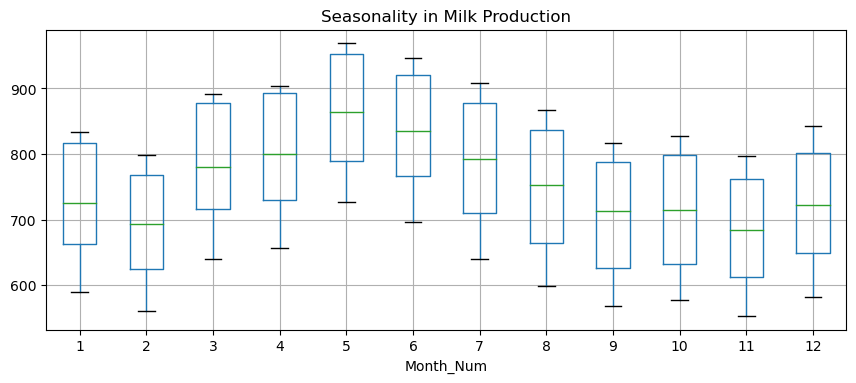

In [27]:
df['Month_Num'] = df.index.month
df.boxplot(column='Milk_Production', by='Month_Num', figsize=(10,4))
plt.title("Seasonality in Milk Production")
plt.suptitle("")
plt.show()


In [28]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Milk_Production']])


In [29]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)


In [30]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test  = X[train_size:]

y_train = y[:train_size]
y_test  = y[train_size:]


In [31]:
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)


In [32]:
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)


In [33]:
gru_model = Sequential([
    GRU(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)


In [34]:
rnn_pred  = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred  = gru_model.predict(X_test)


1/1 [==============================] - 0s 352ms/step


In [35]:
rnn_pred  = scaler.inverse_transform(rnn_pred)
lstm_pred = scaler.inverse_transform(lstm_pred)
gru_pred  = scaler.inverse_transform(gru_pred)

y_test_actual = scaler.inverse_transform(y_test)


In [36]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape


In [37]:
print("RNN  :", evaluate_model(y_test_actual, rnn_pred))
print("LSTM :", evaluate_model(y_test_actual, lstm_pred))
print("GRU  :", evaluate_model(y_test_actual, gru_pred))


RNN  : (16.0194969177246, 19.605470791628196, 1.8875363928838194)
LSTM : (48.93513298034668, 55.88502792679133, 5.726824581996057)
GRU  : (39.060974121093736, 48.6690882666411, 4.4790353584800044)


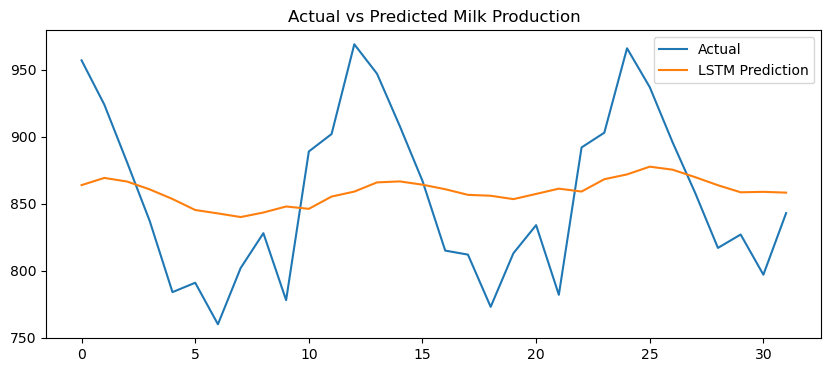

In [38]:
plt.figure(figsize=(10,4))
plt.plot(y_test_actual, label='Actual')
plt.plot(lstm_pred, label='LSTM Prediction')
plt.title("Actual vs Predicted Milk Production")
plt.legend()
plt.show()


In [39]:
future_input = scaled_data[-window_size:]
future_predictions = []

for _ in range(12):
    pred = lstm_model.predict(future_input.reshape(1, window_size, 1))
    future_predictions.append(pred[0,0])
    future_input = np.vstack([future_input[1:], pred])


1/1 [==============================] - 0s 25ms/step


In [40]:
future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1,1)
)


In [41]:
future_dates = pd.date_range(
    start=df.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)


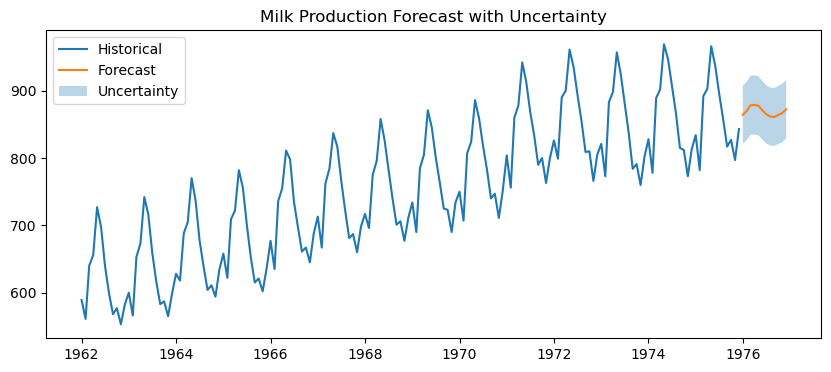

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df['Milk_Production'], label='Historical')
plt.plot(future_dates, future_predictions, label='Forecast')

plt.fill_between(
    future_dates,
    future_predictions.flatten() * 0.95,
    future_predictions.flatten() * 1.05,
    alpha=0.3,
    label='Uncertainty'
)

plt.title("Milk Production Forecast with Uncertainty")
plt.legend()
plt.show()


In [43]:
results = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU'],
    'MAE': [
        evaluate_model(y_test_actual, rnn_pred)[0],
        evaluate_model(y_test_actual, lstm_pred)[0],
        evaluate_model(y_test_actual, gru_pred)[0]
    ],
    'RMSE': [
        evaluate_model(y_test_actual, rnn_pred)[1],
        evaluate_model(y_test_actual, lstm_pred)[1],
        evaluate_model(y_test_actual, gru_pred)[1]
    ],
    'MAPE': [
        evaluate_model(y_test_actual, rnn_pred)[2],
        evaluate_model(y_test_actual, lstm_pred)[2],
        evaluate_model(y_test_actual, gru_pred)[2]
    ]
})

results


,Model,MAE,RMSE,MAPE
0,RNN,16.019497,19.605471,1.887536
1,LSTM,48.935133,55.885028,5.726825
2,GRU,39.060974,48.669088,4.479035


In [ ]:
#Business Insights:

#The milk production data shows strong seasonal patterns.
#Among the deep learning models, LSTM and GRU outperform the basic RNN as they better capture long-term dependencies.
#The 12-month forecast helps the dairy business plan inventory, workforce allocation, and distribution more effectively.
#The uncertainty band provides a risk-aware forecast range, supporting better strategic planning.
#This analysis enables improved demand forecasting and reduced operational risk.
